### replace default value of argument (e.g. `gamma`, `hi_min`) to defined values in module file

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import rcParams
rcParams['font.size'] = 15

In [2]:
# from math import sqrt
# from numbers import Real

# def get_stepsize_quad(ti, xi, Fx, dxFx, dx2Fx, hi_max,
#                      gamma = 0.8, hi_min = 0.0001, forward=True):
    
#     if not forward: raise NotImplementedError(
#         "backward time flow hasn't been dealt yet")
#     assert isinstance(gamma, Real) and (0 < gamma) and (gamma < 1)
    
#     _hi_guess = None
    
#     ## initial guess of stepsize
#     _F_0, _dxFx_0, _dx2Fx_0 = Fx(ti,xi), dxFx(ti,xi), dx2Fx(ti,xi)
#     _a1_0 = _dxFx_0*_dxFx_0 - 2.0 * _dx2Fx_0 * _F_0
#     _a2_0 = _dxFx_0
#     _D_D = _a2_0 * _a2_0 - _a1_0
    
#     if _a1_0 > 0:
#         if _a2_0 <= 0: _hi_guess = hi_max
#         else:
#             if _D_D >= 0: _hi_guess = gamma * _a2_0 / _a1_0
#             else: _hi_guess = hi_max
#     elif _a1_0 < 0: _hi_guess = gamma*(_a2_0+sqrt(_D_D)) / (2.0*_a1_0)
#     elif _a1_0 == 0:
#         if _a2_0 > 0: _hi_guess = gamma / (2.0*_a2_0)
#         else: _hi_guess = hi_max
#     else: raise Exception("Unexpected")
    
#     assert isinstance(_hi_guess, Real)
#     _D_hi_0 = _a1_0 * _hi_guess*_hi_guess - 2.0 * _a2_0 * _hi_guess + 1
#     assert _D_hi_0 > 0

    
#     ## fine-tune
#     _a1, _a2 = _a1_0, _a2_0
#     while _hi_guess > hi_min:
#         _D_hi = _a1 * _hi_guess*_hi_guess - 2.0 * _a2 * _hi_guess + 1
#         if _D_hi > 0: break
#         print("reduced")
#         _ti = ti + _hi_guess
#         _F, _dxFx, _dx2Fx = Fx(_ti,xi), dxFx(_ti,xi), dx2Fx(_ti,xi)
#         _a1 = _dxFx*_dxFx - 2.0 * _dx2Fx * _F
#         _a2 = _dxFx
#         _hi_guess *= gamma
    
#     if (_hi_guess <= hi_min):
#         raise Exception("hi_min reached-couldn't find good stepsize")
#     _hi = min(_hi_guess, hi_max)
    
#     return _hi

# import numpy as np
# from scipy.optimize import root

# def back_euler_quad(t0, x0, t_max, Fx, dxFx, dx2Fx, hi_max, 
#                     t_arr=None, **stepsize_kwarg):
    
#     if t_arr is None: t_arr = np.array((t0, t_max))
#     else: assert isinstance(t_arr, np.ndarray) and (t_arr.ndim == 1)
#     assert t0 == t_arr[0]

#     _x_arr = np.empty_like(t_arr, dtype=float)
#     _x_arr[0] = x0
#     _t, _x = t0, x0
    
#     for _i in range(1,t_arr.size):
        
#         _t_target = t_arr[_i]
        
#         while _t < _t_target:
#             _h = get_stepsize_quad(_t, _x, Fx, dxFx, dx2Fx, hi_max, 
#                                    **stepsize_kwarg)
#             _t_next = _t + _h
#             if _t_next > _t_target:
#                 _h = _t_target - _t
#                 _t_next = _t_target
                
#             def _Gx(x): return (x - _x) - _h * Fx(_t_next, x)
#             _sol = root(_Gx, _x)  # jacobian may be supplied
#             if _sol.success and _sol.x.size == 1: _x_next, = _sol.x
#             else: raise Exception(
#                 "unique root search failed due to '{}'".format(
#                     _sol.message))
#             _t, _x = _t_next, _x_next
            
#         _x_arr[_i] = _x_next

#     return t_arr, _x_arr


In [2]:
from bohm.ode.euler import get_stepsize, back_euler

In [3]:
# import numpy as np
# from scipy.optimize import root

# def back_euler(t0, x0, t_max, Fx, dxFx, hi_max, 
#                     t_arr=None, **stepsize_kwarg):
    
#     if t_arr is None: t_arr = np.array((t0, t_max))
#     else: assert isinstance(t_arr, np.ndarray) and (t_arr.ndim == 1)
#     assert t0 == t_arr[0]

#     _x_arr = np.empty_like(t_arr, dtype=float)
#     _x_arr[0] = x0
#     _t, _x = t0, x0
    
#     for _i in range(1,t_arr.size):
        
#         _t_target = t_arr[_i]
        
#         while _t < _t_target:
#             _h = get_stepsize(_t, _x, Fx, dxFx, hi_max, 
#                                    **stepsize_kwarg)
#             _t_next = _t + _h
#             if _t_next > _t_target:
#                 _h = _t_target - _t
#                 _t_next = _t_target
                
#             def _Gx(x): return (x - _x) - _h * Fx(_t_next, x)
#             _sol = root(_Gx, _x)  # jacobian may be supplied
#             if _sol.success and _sol.x.size == 1: _x_next, = _sol.x
#             else: raise Exception(
#                 "unique root search failed due to '{}'".format(
#                     _sol.message))
#             _t, _x = _t_next, _x_next
            
#         _x_arr[_i] = _x_next

#     return t_arr, _x_arr


### Test for several set of initial values

## How can I find those kind of `t0+1/x0` singular point .. where propagation is not possible .. although,, in Bohm, there is always solution if started from regular point -- thus, small enough stepsize always exist to

In [3]:
# import numpy as np
# from numbers import Real

# def get_sol_linear(t0, x0, c0, c1):
#     for _var in (t0, x0, c0, c1): assert isinstance(_var, Real)
#     if c1 == 0: return lambda t: c0 * (t - t0) + x0
#     else: return lambda t: (x0 + c0/c1) * np.exp(c1 * (t - t0)) - c0/c1

In [4]:
# c0, c1, c2 = 0, 0, 1
# def Fx(t, x): return c0 + c1 * x + c2 * x*x
# def dxFx(t, x): return c1 + 2.0*c2*x
# def dx2Fx(t, x): return 2.0 * c2

kx = 0.0
def Fx(t,x): return (kx + 4.0*x*t) / (1.0 + 4.0 * t*t)
def dxFx(t,x): return -4.0*t / (1.0 + 4.0 * t*t)
def dx2Fx(t,x): return 0.0


t0, x0_arr = -3, np.linspace(-3, 3, 8)
t_max = 3

t_arr = np.linspace(t0, t_max, 10)
x_t_arr = np.empty((t_arr.size, x0_arr.size), dtype=float)
x_t_arr[0,:] = x0_arr

# assert np.all(t_max < (t0 + 1/x0_arr))

h_max, gamma, h_min = 0.01, 0.5, 0.0001

for i in range(x0_arr.size):
    _, x_arr = back_euler_quad(t0, x0_arr[i], t_max, Fx, dxFx, dx2Fx, 
                               h_max, t_arr=t_arr, gamma=gamma, hi_min=h_min)
    x_t_arr[:,i] = x_arr

# f_t_arr = np.empty_like(x_t_arr)
    
# def x_analytic(t,x0): return - 1.0 / (t - t0 - 1.0/x0)
# for i in range(x0_arr.size):
#     f_t_arr[:,i] = x_analytic(t_arr, x0_arr[i])
    
# c0 = kx / (1.0 + 4.0 * t*t)
# c1 = -4.0*t / (1.0 + 4.0 * t*t)
# for i in range(x0_arr.size):
#     f_t_arr[:,i] = get_sol_linear(t0, x0_arr[i], c0, c1)(t_arr)

NameError: name 'back_euler_quad' is not defined

# compare implicit and explicit Euler

In [3]:
from tdse.analytic.state import Gaussian1D, gradient_Gaussian1D, laplacian_Gaussian1D

A1, A2 = 1.0, 0.7
kx1, kx2 = 0.0, 0.0
xc1, xc2 = -1.0, 1.0
t01, t02 = -0.3, 0.0
def psi(t,x): return A1 * Gaussian1D(x-xc1,t-t01,kx1) + A2 * Gaussian1D(x-xc2,t-t02,kx2)
def dxpsi(t,x): return A1 * gradient_Gaussian1D(x-xc1,t-t01,kx1) + A2 * gradient_Gaussian1D(x-xc2,t-t02,kx2)
def dx2psi(t,x): return A1 * laplacian_Gaussian1D(x-xc1,t,kx1) + A2 * laplacian_Gaussian1D(x-xc2,t,kx2)

def Fx(t,x): return (dxpsi(t,x) / psi(t,x)).imag
def dxFx(t,x): return (dx2psi(t,x)/psi(t,x) - (dxpsi(t,x)/psi(t,x))**2).imag
# def dx2Fx(t,x): return 0.0

t0, x0_arr = -3, np.linspace(-3, 1, 30)
t_max = 3

assert np.all(np.abs(psi(t0, x0_arr)) != 0)

t_arr = np.linspace(t0, t_max, 30)
x_t_arr = np.empty((t_arr.size, x0_arr.size), dtype=float)
x_t_arr[0,:] = x0_arr

h_max, gamma, h_min = 0.01, 0.5, 0.0001

for i in range(x0_arr.size):
    _, x_arr = back_euler(t0, x0_arr[i], t_max, Fx, dxFx, h_max, t_arr=t_arr, gamma=gamma, hi_min=h_min)
#     _, x_arr = back_euler_quad(t0, x0_arr[i], t_max, Fx, dxFx, dx2Fx, 
#                                h_max, t_arr=t_arr, gamma=gamma, hi_min=h_min)
    x_t_arr[:,i] = x_arr

In [4]:
from vis.plot import construct_catesian_mesh_for_pcolormesh

t_grid_vals = np.linspace(t0, t_max, 50)
x_grid_vals = np.linspace(x_t_arr.min(), x_t_arr.max(), 50)
T_grid, X_grid = construct_catesian_mesh_for_pcolormesh(t_grid_vals, x_grid_vals)
T, X = np.meshgrid(t_grid_vals, x_grid_vals, indexing='ij')

In [5]:
from matplotlib.colors import LogNorm

psi_val = psi(T, X)
C = np.square(np.abs(psi_val))
vmax = C.max()
vmin = vmax * pow(10, -1.4)
norm = LogNorm(vmin, vmax)

# Implement sampling from the initial distribution

Text(0, 0.5, 'x / a.u.')

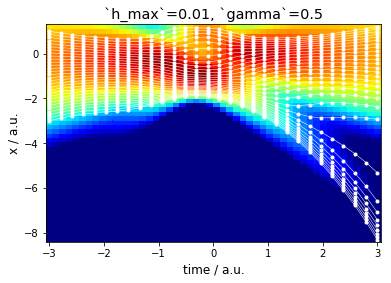

In [6]:
fig, ax = plt.subplots()

ax.pcolormesh(T_grid, X_grid, C, cmap='jet', norm=norm)

for i in range(x0_arr.size):
#     l_ana, = ax.plot(t_arr, f_t_arr[:,i])
    l_num, = ax.plot(t_arr, x_t_arr[:,i], '.-', color='white', linewidth=0.5)

#     ax.plot(t0, x0_arr[i], 'o', color=l_num.get_color())

ax.set_xlim(T_grid.min(), T_grid.max())
ax.set_ylim(X_grid.min(), X_grid.max())

ax.set_title("`h_max`={}, `gamma`={}".format(h_max, gamma))
# ax.legend((l_ana, l_num), ("analytic", "numeric"))
ax.set_xlabel("time / a.u.")
ax.set_ylabel("x / a.u.")

In [7]:
# fig.savefig("step-esti-two-gaussian-A1-{}-A2-{}-t01-{}-t02-{}-hmax-{}-gamma-{}-with-map-test-7.png".format(A1, A2, t01, t02, h_max,gamma))